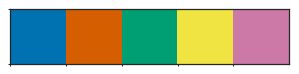

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rpy2.robjects as robj
from scipy import stats
import pysam

%load_ext rpy2.ipython
robj.pandas2ri.activate()

%matplotlib inline

sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
sns.set_palette(pal)
sns.palplot(pal)
plt.show()


To test whether template G4 dense genes might produce abortive transcripts that are degraded by the exosome rather than maturing to mRNAs, we analysed publicly available GRO-seq data [(Hetzel et al. 2016)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5087027/). Raw data was downloaded from GEO and remapped using STAR. Exonic read counts were then tallied using featureCounts. DESeq2 was used to normalise read counts by library depth and log2 ratios for GRO/RNAseq counts were calculated. Since GRO-seq captures nascent RNA irrespective of its stability, and RNAseq captures stable RNAs, this ratio represents an estimate of the amount of unstable products produced at each gene loci. We found that the largest difference in ratio was between non-coding and protein coding RNAs, with non-coding RNAs having much greater GRO/RNA ratios. This is likely explained by the higher rate of modification of many ncRNAs, e.g. tRNAs, which prevent reverse transcription and sequencing by RNAseq. Other ncRNAs such as natural antisense RNAs may also be unstable and degraded quickly.

G4 predictions were calculated using G4Seeqer and the score of the maximum score region within the transcribed body of each gene was assigned to the gene. A G4 containing set was produced using genes which contained a maximum template strand G4seeqer score of more than 0.95, and a G4 negative set was produced using genes with a maximum score of only 0.05 or less. We found a small but significant positive increase in GRO/RNA ratio for G4 dense genes (p = 0.009), suggesting that more abortive transcripts are produced from these genes. In contrast, genes with high scoring G4 regions on the coding strand did not have greater GRO/RNA ratios (p=0.4).

In [14]:
%%R -o lengths,gene_ids,counts
library(ggplot2)
library(DESeq2)

print(sessionInfo())

counts <- read.table('/home/matthew/iceberg_fastdata/groseq/exon_counts.tsv',
                     comment='#', header=TRUE, row.names = 1)
gene_ids <- rownames(counts)
lengths <- counts$Length
counts <- counts[,7:ncol(counts)]
counts <- counts[rowSums(counts > 1) >= 2,]
colnames(counts) <- c('gro_1', 'gro_2', 'rna_1', 'rna_2')
colData <- data.frame(row.names=colnames(counts), 
                      exp_type=rep(c('gro', 'rna'), each=2))
dds <- DESeqDataSetFromMatrix(counts, colData = colData, design = ~ exp_type)
dds <- estimateSizeFactors(dds)

R version 3.4.1 (2017-06-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.4 LTS

Matrix products: default
BLAS: /home/matthew/anaconda3/envs/ml_python35/lib/R/lib/libRblas.so
LAPACK: /home/matthew/anaconda3/envs/ml_python35/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] parallel  stats4    tools     stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] DESeq2_1.18.1              SummarizedExperiment_1.8.0
 [3] DelayedArray_0.4.1         matrixStats_0.52.2        
 [5] Biobase_2.38.0             GenomicRanges_1.30.3      
 [7] GenomeInfoDb_1.14.0     

/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in file(file, "rt") : cannot open the connection

  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In addition: 
  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Warning message:

  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In file(file, "rt") :
  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
 
  warnings.warn(x, RRuntimeWarning)
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWa

In [3]:
%%R
logcpm <- log2(counts(dds, normalized=TRUE))
logcpm[is.infinite(logcpm)] <- 0
logcpm <- as.data.frame(logcpm)
logcpm[,'gro_av_exprs'] = rowMeans(logcpm[,1:2])
logcpm[,'rna_av_exprs'] = rowMeans(logcpm[,3:4])
g <- ggplot(data=logcpm, mapping=aes(x=gro_av_exprs, y=rna_av_exprs))
g <- g + geom_point(shape='x')
g


Error in counts(dds, normalized = TRUE) : object 'dds' not found


/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in counts(dds, normalized = TRUE) : object 'dds' not found

  warnings.warn(x, RRuntimeWarning)


In [4]:
%%R -o logcpm
logcpm[,'log_gro_rna_ratio'] = logcpm[,'gro_av_exprs'] - logcpm[,'rna_av_exprs']


Error in withVisible({ : object 'logcpm' not found


/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in withVisible({ : object 'logcpm' not found

  warnings.warn(x, RRuntimeWarning)


In [5]:
%%R -o res
dds <- DESeq(dds, )
res <- as.data.frame(results(dds, contrast=c('exp_type', 'gro', 'rna')))


Error in is(object, "DESeqDataSet") : object 'dds' not found


/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in is(object, "DESeqDataSet") : object 'dds' not found

  warnings.warn(x, RRuntimeWarning)


In [6]:
res.sort_values('padj', ascending=True).head(n=25)

NameError: name 'res' is not defined

In [ ]:
%%bash
source activate ml_python35
g4seeqer -ts 0 -p 4 \
  -f /home/matthew/Documents/genomes/tair10/fasta/tair10_genome.fa \
  -b /tmp/tair10_g4_g4seeqer.bed

In [ ]:
!head  /tmp/tair10_g4_g4seeqer.bed

In [ ]:
%%bash
source activate cgat_python2

sort -k1,1 -k2,2n /tmp/tair10_g4_g4seeqer.bed > /tmp/tair10_g4_g4seeqer.sorted.bed

bedtools map -c 4 -o max -s -prec 2 -F 0.75 \
  -a /home/matthew/Documents/genomes/tair10/gff/araport11_genes.bed \
  -b /tmp/tair10_g4_g4seeqer.sorted.bed > /tmp/g4seeqer_pos_max_score.bed

bedtools map -c 4 -o max -S -prec 2 -F 0.75 \
  -a /home/matthew/Documents/genomes/tair10/gff/araport11_genes.bed \
  -b /tmp/tair10_g4_g4seeqer.sorted.bed > /tmp/g4seeqer_neg_max_score.bed

In [ ]:
!head /tmp/g4seeqer_pos_max_score.bed

In [ ]:
colnames = ['chrom', 'start', 'end', 'gene_id', 'score', 'strand', 'max_g4seeqer_score']
converters = {'gene_id': str,
              'max_g4seeqer_score': lambda x: 0 if x == '.' else float(x)}
pos_g4seeqer = pd.read_csv('/tmp/g4seeqer_pos_max_score.bed',
                           sep='\t',
                           names=colnames,
                           converters=converters,
                           usecols=['gene_id', 'max_g4seeqer_score'])
neg_g4seeqer = pd.read_csv('/tmp/g4seeqer_neg_max_score.bed',
                           sep='\t',
                           names=colnames,
                           converters=converters,
                           usecols=['gene_id', 'max_g4seeqer_score'])

g4seeqer_score = pos_g4seeqer.merge(neg_g4seeqer,
                                    on='gene_id',
                                    suffixes=('_coding', '_template'))
g4seeqer_score = g4seeqer_score.set_index('gene_id')
g4seeqer_score.head()                          

In [7]:
%%bash
source activate cgat_python2
g4predict intra \
  -f /home/matthew/Documents/genomes/tair10/fasta/tair10_genome.fa \
  -b /tmp/tair10_g4.bed \
  -s \
  -F \
  -tmin 2 \
  -tmax 2 \
  -lmin 1 \
  -lmax 7

INFO:root:Output from G4Predict
INFO:root:Parsing command line arguments
INFO:root:Running in mode: intra
INFO:root:Parameters:
{       'bed': '/tmp/tair10_g4.bed',
        'fasta': '/home/matthew/Documents/genomes/tair10/fasta/tair10_genome.fa',
        'filter_overlapping': True,
        'func': <function intra at 0x7fde5cc89b90>,
        'merge_overlapping': False,
        'write_bed12': False,
        'write_bed6': True}
INFO:root:G4 Parameters: 
{       'bulge_kwargs': {       'bulges_allowed': 0, 'start': 1, 'stop': 5},
        'inter_kwargs': {       'start': 2, 'stop': 3},
        'loop_kwargs_list': [       {       'allow_G': 1, 'start': 1, 'stop': 7},
                                    {       'allow_G': 1, 'start': 1, 'stop': 7},
                                    {       'allow_G': 1, 'start': 1, 'stop': 7}],
        'score_kwargs': {       'bulge_pen_factor': 5,
                                'loop_pen_factor': 1.5,
                                'tetrad_score_factor':

In [8]:
%%bash
source activate cgat_python2

bedtools makewindows \
  -g /home/matthew/Documents/genomes/tair10/tair10.chrom.sizes \
  -w 200 -s 25 -i srcwinnum | tee >(\
    awk -v OFS="\t" '{print $0 "_pos", ".", "+"}'  > /tmp/windows_pos.bed) | \
    awk -v OFS="\t" '{print $0 "_neg", ".", "-"}'  > /tmp/windows_neg.bed
cat /tmp/windows_pos.bed /tmp/windows_neg.bed | \
sort -k1,1 -k2,2n > /tmp/windows.bed

In [9]:
%%bash
source activate cgat_python2

bedtools map -c 4 -o count -s \
  -a /tmp/windows.bed \
  -b /tmp/tair10_g4.bed | \
awk -v OFS="\t" '{print $1, $2, $3, $4, $7, $6}' \
  > /tmp/g4_windowed_counts.bed

In [10]:
%%bash
source activate cgat_python2

bedtools map -c 5 -o max -s -prec 1 -F 0.75 \
  -a /home/matthew/Documents/genomes/tair10/gff/araport11_genes.bed \
  -b /tmp/g4_windowed_counts.bed > /tmp/g4_pos_maximal_density.bed

bedtools map -c 5 -o max -S -prec 1 -F 0.75 \
  -a /home/matthew/Documents/genomes/tair10/gff/araport11_genes.bed \
  -b /tmp/g4_windowed_counts.bed > /tmp/g4_neg_maximal_density.bed

In [11]:
protein_coding_genes = !cut -f4 /home/matthew/Documents/genomes/tair10/gff/Araport11_protein_coding.201606.bed | cut -d "." -f1
protein_coding_genes = set(protein_coding_genes)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(x='gro_av_exprs',
           y='rna_av_exprs',
           data=logcpm[prot_coding],
           alpha=0.2, s=8,
           rasterized=True)
ax.plot([-1, 18], [-1, 18], ls='--', c=pal[1], lw=2)
ax.set_xlim(-1, 18)
ax.set_ylim(-1, 18)
ax.set_xlabel('GROseq Av. Expression')
ax.set_ylabel('RNAseq Av. Expression')
plt.tight_layout()
plt.savefig('gro_vs_rna_logcpm.svg')
plt.show()

In [ ]:
colnames = ['chrom', 'start', 'end', 'gene_id', 'score', 'strand', 'max_g4_density']
converters = {'gene_id': str,
              'max_g4_density': lambda x: 0 if x == '.' else round(float(x))}
pos_g4_density = pd.read_csv('/tmp/g4_pos_maximal_density.bed',
                             sep='\t',
                             names=colnames,
                             converters=converters,
                             usecols=['gene_id', 'max_g4_density'])
neg_g4_density = pd.read_csv('/tmp/g4_neg_maximal_density.bed',
                             sep='\t',
                             names=colnames,
                             converters=converters,
                             usecols=['gene_id', 'max_g4_density'])

g4_max_density = pos_g4_density.merge(neg_g4_density,
                                      on='gene_id',
                                      suffixes=('_coding', '_template'))
g4_max_density = g4_max_density.set_index('gene_id')
g4_max_density.head()                          

In [ ]:
gro_g4 = res_prot_coding.join(g4seeqer_score, how='left')
fig, axes = plt.subplots(figsize=(10, 5), ncols=2, sharey=True)
g4_neg = gro_g4.max_g4seeqer_score_coding < 0.05
g4_pos = gro_g4.max_g4seeqer_score_coding >= 0.95
sns.distplot(gro_g4[g4_neg].log_gro_rna_ratio, label='non-G4', bins=np.linspace(-6, 6, 15), ax=axes[0])
sns.distplot(gro_g4[g4_pos].log_gro_rna_ratio, label='G4', bins=np.linspace(-6, 6, 15), ax=axes[0])
axes[0].set_xlim(-4, 8)
axes[0].set_xlabel('Log2 GRO / RNAseq reads')
print(stats.ttest_ind(gro_g4[g4_neg].log_gro_rna_ratio, gro_g4[g4_pos].log_gro_rna_ratio))
g4_neg = gro_g4.max_g4seeqer_score_template < 0.05
g4_pos = gro_g4.max_g4seeqer_score_template >= 0.95
sns.distplot(gro_g4[g4_neg].log_gro_rna_ratio, label='non-G4', bins=np.linspace(-6, 6, 15), ax=axes[1])
sns.distplot(gro_g4[g4_pos].log_gro_rna_ratio, label='G4', bins=np.linspace(-6, 6, 15), ax=axes[1])
axes[1].set_xlim(-4, 8)
axes[1].set_xlabel('Log2 GRO / RNAseq reads')
axes[0].set_ylabel('Density')
print(stats.ttest_ind(gro_g4[g4_neg].log_gro_rna_ratio, gro_g4[g4_pos].log_gro_rna_ratio))
plt.legend()
plt.savefig('gro_rna_ratio_g4seeqer.svg')
plt.show()

In [ ]:
gro_g4 = res_prot_coding.join(g4_max_density, how='left')
fig, axes = plt.subplots(figsize=(10, 5), ncols=2, sharey=True)
g4_neg = gro_g4.max_g4_density_coding < 1
g4_pos = gro_g4.max_g4_density_coding > 3
sns.distplot(gro_g4[g4_neg].log_gro_rna_ratio, label='non-G4', bins=np.linspace(-6, 6, 15), ax=axes[0])
sns.distplot(gro_g4[g4_pos].log_gro_rna_ratio, label='G4', bins=np.linspace(-6, 6, 15), ax=axes[0])
axes[0].set_xlim(-4, 8)
axes[0].set_xlabel('Log2 GRO / RNAseq reads')
print(stats.ttest_ind(gro_g4[g4_neg].log_gro_rna_ratio, gro_g4[g4_pos].log_gro_rna_ratio))
g4_neg = gro_g4.max_g4_density_template < 1
g4_pos = gro_g4.max_g4_density_template > 3
sns.distplot(gro_g4[g4_neg].log_gro_rna_ratio, label='non-G4', bins=np.linspace(-6, 6, 15), ax=axes[1])
sns.distplot(gro_g4[g4_pos].log_gro_rna_ratio, label='G4', bins=np.linspace(-6, 6, 15), ax=axes[1])
axes[1].set_xlim(-4, 8)
axes[1].set_xlabel('Log2 GRO / RNAseq reads')
axes[0].set_ylabel('Density')
print(stats.ttest_ind(gro_g4[g4_neg].log_gro_rna_ratio, gro_g4[g4_pos].log_gro_rna_ratio))
plt.legend()
plt.savefig('gro_rna_ratio_g4_max_density.svg')
plt.show()

In [ ]:
stats.ttest_ind(gro_g4[g4_neg].log_gro_rna_ratio, gro_g4[g4_pos].log_gro_rna_ratio)

In [ ]:
!head /home/matthew/sharc_fastdata/groseq/gro_vs_rna_counts.tsv

In [ ]:
%%R -o gene_ids

hg38_counts <- read.table('/home/matthew/sharc_fastdata/groseq/gro_vs_rna_counts.tsv',
                          comment='#', header=TRUE, row.names = 1)
hg38_counts <- hg38_counts[,6:ncol(hg38_counts)]
hg38_counts <- hg38_counts[rowSums(hg38_counts > 1) >= 2,]
colnames(hg38_counts) <- c('gro_1', 'gro_2', 'rna_1', 'rna_2')
hg38_colData <- data.frame(row.names=colnames(hg38_counts), 
                           exp_type=rep(c('gro', 'rna'), each=2))
hg38_dds <- DESeqDataSetFromMatrix(hg38_counts, colData = hg38_colData, design = ~ exp_type)
hg38_dds <- estimateSizeFactors(hg38_dds)

In [ ]:
%%R
hg38_logcpm <- log2(counts(hg38_dds, normalized=TRUE))
hg38_logcpm[is.infinite(hg38_logcpm)] <- 0
hg38_logcpm <- as.data.frame(hg38_logcpm)
hg38_logcpm[,'gro_av_exprs'] = rowMeans(hg38_logcpm[,1:2])
hg38_logcpm[,'rna_av_exprs'] = rowMeans(hg38_logcpm[,3:4])
g <- ggplot(data=hg38_logcpm, mapping=aes(x=gro_av_exprs, y=rna_av_exprs))
g <- g + geom_point(shape='x')
g

In [ ]:
%%R -o hg38_logcpm
hg38_logcpm[,'log_gro_rna_ratio'] = hg38_logcpm[,'gro_av_exprs'] - hg38_logcpm[,'rna_av_exprs']

In [ ]:
hg38_logcpm.head()

In [ ]:
sns.distplot(hg38_logcpm.log_gro_rna_ratio)
plt.show()

In [ ]:
%%bash
awk '$3 == "transcript"' /home/matthew/sharc_fastdata/groseq/hg38_geneset.gtf | \
grep "protein_coding" | \
awk '{print $10}' | uniq | \
sed 's/[";]//g' > ./hg38_prot_coding.txt

In [ ]:
hg38_prot_coding = !cat hg38_prot_coding.txt
hg38_prot_coding = set([x.strip() for x in hg38_prot_coding])

In [ ]:
sns.distplot(hg38_logcpm[hg38_logcpm.index.isin(hg38_prot_coding)].log_gro_rna_ratio, label='prot-coding')
sns.distplot(hg38_logcpm[~hg38_logcpm.index.isin(hg38_prot_coding)].log_gro_rna_ratio, label='non-coding')
plt.legend(loc=0)
plt.show()

In [66]:
%%bash
source activate ml_python35
g4seeqer -ts 0 -p 4 \
  -f /home/matthew/iceberg_shared/General/mirror/genomes/faidx/hg38.fa \
  -b hg38_g4seeqer.bed

2018-04-11 18:22:07.456321: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
Using TensorFlow backend.


In [83]:
%%bash
source activate cgat_python2
zcat  /home/matthew/iceberg_shared/General/annotations/hg38_ensembl85/ensembl.dir/geneset_all.gtf.gz |
cgat gtf2gtf --method="merge-transcripts" -L /dev/null | \
awk -v OFS='\t' '{print $1, $4, $5, $10, ".", $7}' | sed 's/[;"]//g' | sort -k1,1 -k2,2n > hg38_genes.bed

In [84]:
%%bash
source activate cgat_python2

sort -k1,1 -k2,2n hg38_g4seeqer.bed > hg38_g4seeqer.sorted.bed

bedtools map -sorted -c 4 -o max -s -prec 2 -F 0.75 \
  -a hg38_genes.bed \
  -b hg38_g4seeqer.sorted.bed > hg38_g4seeqer_pos_max_score.bed

bedtools map -sorted -c 4 -o max -S -prec 2 -F 0.75 \
  -a hg38_genes.bed \
  -b hg38_g4seeqer.sorted.bed > hg38_g4seeqer_neg_max_score.bed

In [85]:
colnames = ['chrom', 'start', 'end', 'gene_id', 'score', 'strand', 'max_g4seeqer_score']
converters = {'gene_id': str,
              'max_g4seeqer_score': lambda x: 0 if x == '.' else float(x)}
hg38_pos_g4seeqer = pd.read_csv('hg38_g4seeqer_pos_max_score.bed',
                                sep='\t',
                                names=colnames,
                                converters=converters,
                                usecols=['gene_id', 'max_g4seeqer_score'])
hg38_neg_g4seeqer = pd.read_csv('hg38_g4seeqer_neg_max_score.bed',
                                sep='\t',
                                names=colnames,
                                converters=converters,
                                usecols=['gene_id', 'max_g4seeqer_score'])

hg38_g4seeqer_score = hg38_pos_g4seeqer.merge(hg38_neg_g4seeqer,
                                              on='gene_id',
                                              suffixes=('_coding', '_template'))
hg38_g4seeqer_score = hg38_g4seeqer_score.set_index('gene_id')
hg38_g4seeqer_score.head()                          

,max_g4seeqer_score_coding,max_g4seeqer_score_template
gene_id,,
ENSG00000223972,0.63,0.60
ENSG00000227232,0.99,0.98
ENSG00000278267,0.00,0.00
ENSG00000243485,0.67,0.98
ENSG00000237613,0.24,0.73


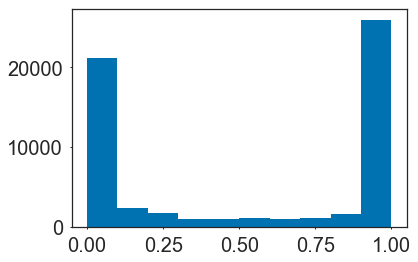

In [88]:
plt.hist(hg38_g4seeqer_score.max_g4seeqer_score_template)
plt.show()

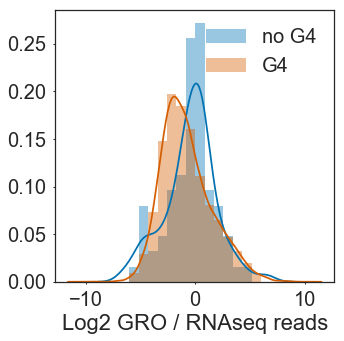

In [102]:
hg38_gro_g4 = hg38_logcpm[hg38_logcpm.index.isin(hg38_prot_coding)].join(hg38_g4seeqer_score, how='left')
fig, ax = plt.subplots(figsize=(5, 5))
g4_neg = hg38_gro_g4.max_g4seeqer_score_template < 0.01
g4_pos = hg38_gro_g4.max_g4seeqer_score_template >= 0.99
sns.distplot(hg38_gro_g4[g4_neg].log_gro_rna_ratio, label='no G4', bins=np.linspace(-6, 6, 15))
sns.distplot(hg38_gro_g4[g4_pos].log_gro_rna_ratio, label='G4', bins=np.linspace(-6, 6, 15))
#ax.set_xlim(-4, 6)
ax.set_xlabel('Log2 GRO / RNAseq reads')
plt.legend()
plt.show()